In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from scipy.signal import lfilter
from math import cos
from scipy.stats.stats import pearsonr

from numba import jit

import PyQt5
from Classes import CrankNicolson, Hamiltonian, EMField,WaveFunction
from Classes.Functions import Math,GroundState

from IPython.display import clear_output
import dill
import cProfile
import csv
%matplotlib notebook

#PMatrix=np.load("../data/PMatrix_8cycle.npy")
aArray=np.load("../data/aArray_4cycle.npy")
#np.show_config()

<h3> Definición de los parámetros

In [3]:
Nx = 4000 #Número de puntos en el mallado espacial
Nt = 16*1024 #Número de puntos en el mallado temporal
x,h = np.linspace(-100,100,Nx,retstep=True) 
a = 1.0 #Paramentro que define el ancho de la función gaussiana
#p0 = 0.0 
x0 = 0.0  #Centro de la función gaussiana a tiempo 0
tmax = 110*4
t,dt = np.linspace(0,tmax,Nt,retstep=True) #Mallado temporal equiespaciado

H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

WF = WaveFunction.WF(a,(x,h),(t,dt),H)
psi = WF.psi
dt

0.026857107977781847

<h3> Máscara de absorción

In [4]:
def Mask(x,xb,gamma):
    mask = np.ones(len(x),dtype='float')
    
    for i in range(len(x)):
        if x[i]<(x[0]+xb):
            mask[i] = np.power(np.cos(np.pi*(x[i]-(x[0]+xb))*gamma/(2*xb)),1/8)
        if x[i]>(x[-1]-xb):
            mask[i] = np.power(np.cos(np.pi*(x[i]-(x[-1]-xb))*gamma/(2*xb)),1/8)
    

    return mask

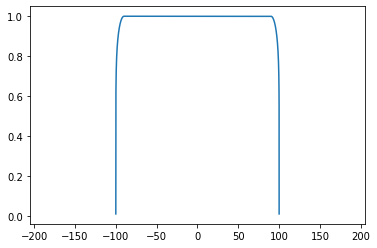

In [5]:
fig = plt.figure();
ax = fig.add_subplot(111); #linear axis
#ax.set_ylim(0,1.5)

mask = Mask(x,10,1.0)
ax.plot(WF.x,mask)
ax.set_xlim(-205,205)
WF.mask = mask

<h3> Representación de la de la densidad de probabiliad de la
onda de partida 

/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


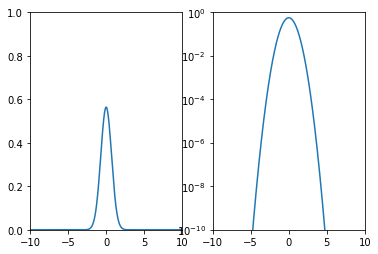

In [6]:
P = WF.P() #Densidad de probabilidad

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)
axli.set_xlim(-10,10)
axlo.set_xlim(-10,10)



axli.plot(WF.x,P);
axlo.plot(WF.x,P);
axlo.set_yscale('log')
plt.show()

<h3> Evolución de la función de onda en ausencia de potencial y campo eléctrico

In [7]:
%%time 

#fig = plt.figure();
#axli = fig.add_subplot(121);
#axlo = fig.add_subplot(122);
#axli.set_ylim(0,1.0)
#axlo.set_ylim(1E-10,1.0)

def evolution():
    PsiArray = []

    #Creamos el Hamiltoniano. En este caso desactivamos la opción del
    #potencial Coulombiano y del potencial vector.
    H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

    #Creamos el propagador con los parámetros deseados
    Prop = CrankNicolson.Propagator(H,Nx,dt)

    #En este caso partimos de la función de onda sin normalizar 
    #para que sea más visual
    WF.psi = WF.WaveFunction()

    for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo

        #Como se trata de un Hamiltoniano constante en el tiempo
        #no hará falta ejecutar Update() en cada iteración, tanto
        #en el Hamiltoniano como en el propagador

        WF.psi = Prop.Propagate(WF.psi) #Propaga de psi0 a psi1 un dt
        WF.psi= WF.psi*WF.mask
        if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
            #axli.plot(x,WF.P(),'b');
            #axlo.plot(x,WF.P(),'b');
            PsiArray.append(WF.psi)
        #psi0 = psi1 #Movemos la función para la próxima iteración
    return PsiArray

#axli.plot(x,WF.P(),'r'); #Representamos el estado final (lineal)
#axlo.plot(x,WF.P(),'r'); #Representamos el estado final (logarítmico)
#axlo.set_yscale('log')

#plt.show()
#Profile.run('evolution()')
psiArray = evolution()

CPU times: user 9.2 s, sys: 3.88 ms, total: 9.21 s
Wall time: 9.28 s


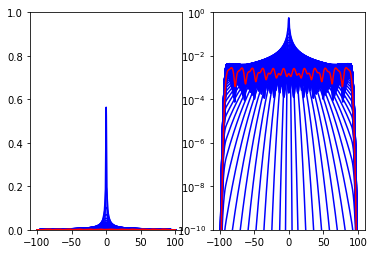

In [8]:
fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)

for i in psiArray:
    WF.psi = i
    axli.plot(x,WF.P(),'b'); #Representamos el estado  (lineal)
    axlo.plot(x,WF.P(),'b'); #Representamos el estado  (logarítmico)
    
axli.plot(x,WF.P(),'r'); #Representamos el estado final (lineal)
axlo.plot(x,WF.P(),'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

<h3>Cálculo del estado fundamental del Hamiltoniano Coulombiano empleando propagación en tiempo imaginario

<h5> Ajuste del parámetro de softening

In [9]:
%%time 

def f(ep):
    return ep+0.5

delta = 1E-5

epdelta = 1E-9
sa = 1.9
sb = 2.1
eps = 1.
count = 0
psi = WF.WaveFunction()

while (eps > epdelta): #Secant method
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sa)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epa = GroundState.GroundState(H,Prop,psi,x,delta)[1]

    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sb)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epb = GroundState.GroundState(H,Prop,psi,x,delta)[1]
                                    
    sc = sb-(f(epb))*(sb-sa)/(f(epb)-f(epa))
    
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epc = GroundState.GroundState(H,Prop,psi,x,delta)[1]
    
    eps = abs(abs(epc)-0.5)
    sa = sb
    sb = sc
    count += 1
                                    
print("epc: "+str(epc))
print("sc: " +str(sc))
print("eps: " + str(eps))
print("Counter: " +str(count))

epc: (-0.4999999999996711+0j)
sc: (2.0357123958882855+0j)
eps: 3.289035710452026e-13
Counter: 4
CPU times: user 6.74 s, sys: 0 ns, total: 6.74 s
Wall time: 6.75 s


<h5> Cálculo del estado fundamental

Energy: (-0.5050338932808774+0j)
Softening Parameter: 2.0
Error: 1.0067786561754888
CPU times: user 3.74 s, sys: 4.01 ms, total: 3.75 s
Wall time: 3.75 s


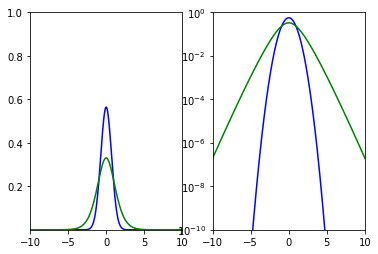

In [10]:
%%time

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(1E-10,1.0)
axlo.set_ylim(1E-10,1.0)
axli.set_xlim(-10,10)
axlo.set_xlim(-10,10)

sc = 2.0
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc)
Prop = CrankNicolson.Propagator(H,Nx,dt)
WF = WaveFunction.WF(a,(x,h),(t,dt),H)

psi = WF.WaveFunction()
psiG,ep = GroundState.GroundState(H,Prop,psi,x,1E-14)
WF.psi = psiG
WF.H = H

axli.plot(x,np.conjugate(psi)*psi,'b')
axli.plot(x,WF.P(),'g')
axlo.plot(x,np.conjugate(psi)*psi,'b')
axlo.plot(x,WF.P(),'g')
axlo.set_yscale('log')
#axli.set_yscale('log')
print("Energy: "+str(WF.Energy()))
print("Softening Parameter: " +str(H.soft))
print("Error: " + str(abs(abs(WF.Energy())-0.5)/0.5*100))


<h3>Propagación con el potencial Coulombiano y con campo 
    eléctrico

In [11]:
%%time

#fig = plt.figure();
#ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
#ax.set_ylim(0,1.0)

#Redefinimos el mallado temporal para este caso
#t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
#x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
WF.psi = psiG
WF.mask = mask
#Creamos un array donde se almacenará la densida de probabilidad
PMatrix = np.zeros((Nt,Nx))
aArray = np.zeros(Nt)

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool = True,softening=sc,tmax=tmax)
WF.H = H
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psiG #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    PMatrix[i] = np.array(WF.P())
    aArray[i] = WF.aExpected()
    WF.psi = WF.mask*np.asarray(Prop.Propagate(WF.psi))
    
    #if (i%100== 0): #Rpresentamos solamente los multiplos de 100
    #    ax.plot(x,np.conjugate(psi1)*psi1,'b')
    
    #psi0 = psi1 #Preparamos para la siguiente iteración

#ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

Calculando el potencial vector...
potencial vector calculado!


/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


CPU times: user 44.7 s, sys: 468 ms, total: 45.1 s
Wall time: 43.9 s


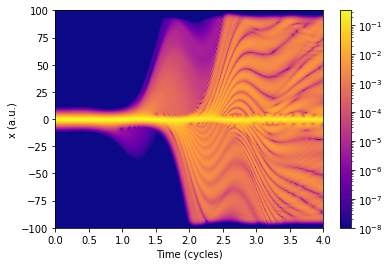

In [12]:
fig = plt.figure();
ax = fig.add_subplot(111);
c = ax.pcolormesh(t/110,x,np.transpose(PMatrix),cmap='plasma',norm=colors.LogNorm(vmin=1E-8,vmax=PMatrix.max()))
fig.colorbar(c, ax=ax)
plt.xlabel("Time (cycles)")
plt.ylabel("x (a.u.)")
#ax.plot(t/110,H.A)
#ax.set_yscale('log')
#ax.set_ylim(-10,10)
plt.show()

<IPython.core.display.Javascript object>


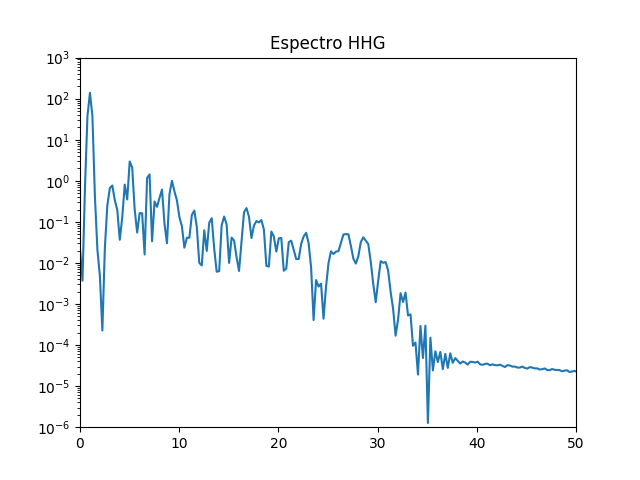

/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [6]:
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(0,)

fourier = np.fft.fft(aArray)
Y = np.conjugate(fourier)*fourier
freq = np.fft.fftfreq(len(fourier))*len(fourier)*(2*np.pi/(dt*Nt))/WF.H.w #https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
ax.set_xlim(0,50)
ax.set_ylim(1e-6,1e3)
ax.plot(freq,Y)
ax.set_yscale('log')

ax.title.set_text("Espectro HHG")

#path = '../data/images/4-cycle/HHG.png'
#plt.savefig(path)
#ax.set_xscale('log')

In [14]:
np.save("../data/PMatrix_4cycle",PMatrix)
np.save("../data/aArray_4cycle",aArray)

In [19]:
np.savetxt("../data/4-cycle-acel.txt", np.real(Y) , fmt='%.18e', delimiter='\t', newline='\n', header='', footer='', comments='# ', encoding=None)

In [10]:
f = open("../data/acel_spec.txt",'r')
N=[]
a = []
with f as file:
    r = csv.reader(file,delimiter='\t')
    for i in r:
        N.append(i[0])
        a.append(i[1])

<IPython.core.display.Javascript object>


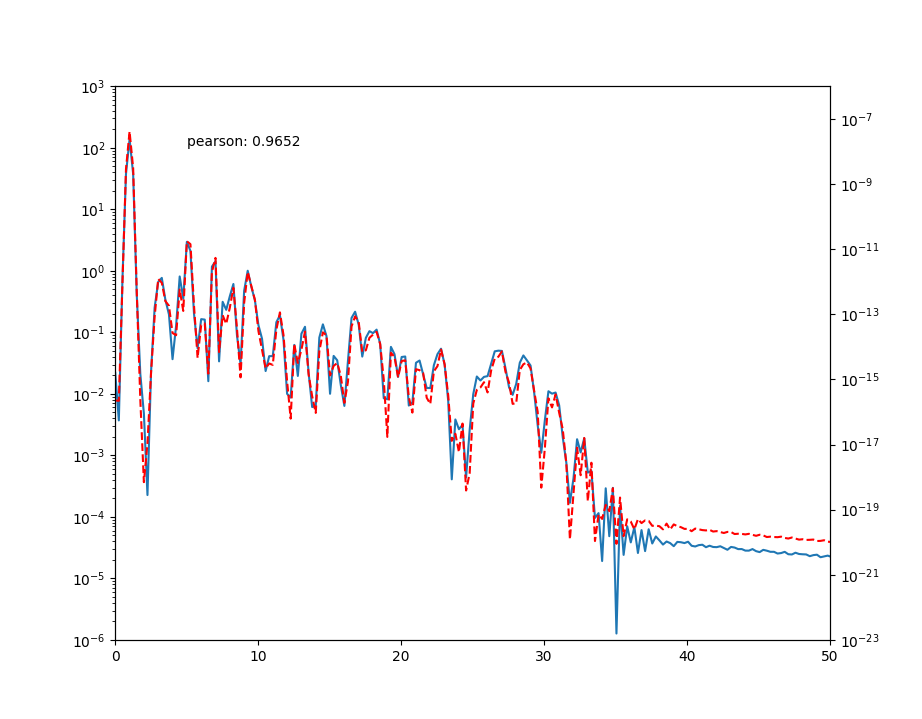

In [37]:
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(0,)

fourier = np.fft.fft(aArray)
Y = np.conjugate(fourier)*fourier
freq = np.fft.fftfreq(len(fourier))*len(fourier)*(2*np.pi/(dt*Nt))/WF.H.w #https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
#freq2 = np.fft.fftfreq(len(a))*len(a)*(2*np.pi/(dt*Nt))/WF.H.w #https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python

c = Y
b = np.array(a).astype(float)*np.array(a).astype(float)


ax.set_xlim(0,50)
ax.set_ylim(1e-6,1e3)

ax.plot(freq,Y)
ax.set_yscale('log')

ax2=ax.twinx()
ax2.set_xlim(0,50)
ax2.set_ylim(1e-23,1e-6)
ax2.set_yscale('log')

ax.text(0.1, 0.9,'pearson: '+str(np.real(pearsonr(c,b))[0].round(4)), ha='left', va='center', transform=ax.transAxes)

ax2.plot(freq,np.array(a).astype(float)*np.array(a).astype(float),'--r')
#ax.title.set_text("Espectro HHG")

In [38]:
re = 2.818E-15/5.292E-11
me = 1
c = 137.04
p = 2/(3*c**3)*Y

<IPython.core.display.Javascript object>


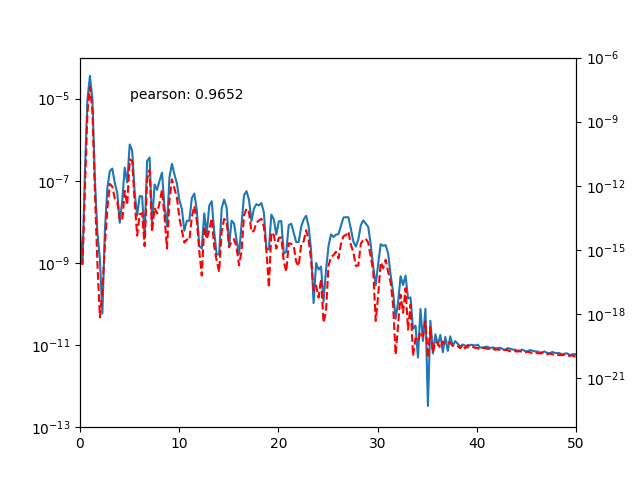

In [39]:
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(0,)

#fourier = np.fft.fft(aArray)
#Y = np.conjugate(fourier)*fourier
freq = np.fft.fftfreq(len(fourier))*len(fourier)*(2*np.pi/(dt*Nt))/WF.H.w #https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
#freq2 = np.fft.fftfreq(len(a))*len(a)*(2*np.pi/(dt*Nt))/WF.H.w #https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python

c = p
b = np.array(a).astype(float)*np.array(a).astype(float)


ax.set_xlim(0,50)
ax.set_ylim(1e-13,1e-4)

ax.plot(freq,p)
ax.set_yscale('log')

ax2=ax.twinx()
ax2.set_xlim(0,50)
ax2.set_ylim(5e-24,1e-6)
ax2.set_yscale('log')

ax.text(0.1, 0.9,'pearson: '+str(np.real(pearsonr(c,b))[0].round(4)), ha='left', va='center', transform=ax.transAxes)

ax2.plot(freq,np.array(a).astype(float)*np.array(a).astype(float),'--r')
#ax.title.set_text("Espectro HHG")

In [26]:
re

1.4912856e-25